In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import credit_card_data

import torch.nn as nn
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
window_size = 15

Z,Y = credit_card_data.generate_raw_data(60, 10000)
train_data, train_label, test_data, test_label = credit_card_data.generate_win_data(Z, Y, window_size)
train_data = torch.tensor(train_data, dtype=torch.float, device=device)
train_label = torch.tensor(train_label, dtype=torch.float, device=device)
test_data = torch.tensor(test_data, dtype=torch.float, device=device)
test_label = torch.tensor(test_label, dtype=torch.float)

In [18]:
print(train_label.size())
print(train_label.sum())

torch.Size([52521])
tensor(3398., device='cuda:0')


In [19]:
i = 0
for z in Z:
    i += int(z[10] != 2)
i

5817

In [20]:
i = 0
for z in Z:
    i += int(z[59] != 2)
i

241

In [21]:
class LSTM(nn.Module):
    def __init__(self, batch_size, output_dim=3):
        super(LSTM, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 3
        self.batch_size = batch_size
        self.num_layers = 2
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        # ("input size: ", input.size())
        lstm_out, hidden = self.lstm(input.view(input.size()[0],input.size()[1],-1))
        y_pred = self.linear(lstm_out[-1])
        y_pred = self.sigmoid(y_pred)
        return y_pred

In [22]:
num_epochs = 10
batch_size = 512
num_train = len(train_data)
output_dim = 1

model = LSTM(batch_size=batch_size, output_dim=output_dim)
model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
for t in range(num_epochs):
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size].permute(1,0)
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = model(batch_data)
        weight = 10 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        loss.backward()
        optimiser.step()

In [24]:
def criteria(y_test, test_label):
    recall = []
    precision = []
    for t in range(102):
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        threshold = t*0.01 - 0.01
        TP += ((y_test > threshold).numpy().flatten()&(test_label == 1).numpy()).sum()
        TN += ((y_test < threshold).numpy().flatten()&(test_label == 0).numpy()).sum()
        FP += ((y_test > threshold).numpy().flatten()&(test_label == 0).numpy()).sum()
        FN += ((y_test < threshold).numpy().flatten()&(test_label == 1).numpy()).sum()
        recall.append((TP) / (TP + FN))
        precision.append((TP) / (TP + FP))
        print(recall[-1], precision[-1])
    return recall, precision

1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
1.0 0.06655331552101044
0.7652068126520681 0.10765017970220778
0.7469586374695864 0.11728748806112703
0.7384428223844283 0.12242839854780153
0.7311435523114356 0.12320623206232062
0.7116788321167883 0.12706342311033883
0.7068126520681265 0.12839779005524862
0.7055961070559611 0.12851761577664525
0.6922141119221411 0.13226406322640633
0.6909975669099757 0.13462905901872482
0.6897810218978102 0.1368

D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan
0.0 nan


(0, 1)

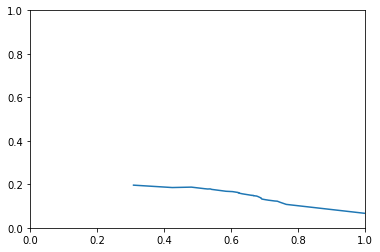

In [25]:
y_test = model(test_data.permute(1,0)).cpu()
recall, precision = criteria(y_test, test_label)
plt.plot(recall, precision)
plt.xlim(0,1)
plt.ylim(0,1)

In [12]:
y_test.min()

tensor(0.2341, grad_fn=<MinBackward1>)

In [13]:
y_test.max()

tensor(0.7196, grad_fn=<MaxBackward1>)

## Focal Loss

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [15]:
def train(loss_fn):
    for t in range(num_epochs):
        for i in range(len(train_data)//batch_size):
            model.zero_grad()
            y_pred = model(train_data[i*batch_size:(i+1)*batch_size])
            loss = loss_fn(y_pred, train_label[i*batch_size:(i+1)*batch_size])
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

In [16]:
loss_2 = FocalLoss()
train(loss_2)

D:\anaconda\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
D:\anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  del sys.path[0]


ValueError: Target and input must have the same number of elements. target nelement (512) != input nelement (10)